<a href="https://colab.research.google.com/github/Ashong-Nartey/Hyperspectral-Image-Classification-/blob/main/HSI_DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import scipy
import os 
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras import backend
backend.set_image_data_format('channels_first')

In [2]:
PATH = os.getcwd()
print (PATH)

/content


In [3]:
# Load the Global values (windowSize, numPCAcomponents, testRatio) from the text file global_variables.txt
myFile = open('global_variables.txt', 'r') 
file = myFile.readlines()[:]


for line in file:

    if line[0:3] == "win":

        ds = line.find('=')
        windowSize = int(line[ds+1:-1],10)

    elif line[0:3] == "num":

        ds = line.find('=')
        numPCAcomponents = int(line[ds+2:-1],10)

    else:

        ds = line.find('=')
        testRatio = float(line[ds+1:])

In [4]:
base_path = "/content/"
X_train = np.load(base_path + "X_trainPatches_" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio)  + ".npy")

y_train = np.load(base_path + "y_trainPatches_" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")

shape_input = X_train[0].shape
print(shape_input)

(5, 5, 30)


In [5]:
# Reshape into (numberofsamples, channels, height, width)
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[3], X_train.shape[1], X_train.shape[2]))

In [6]:
# convert class labels to on-hot encoding
y_train = np_utils.to_categorical(y_train)
output = y_train[0].shape
print(output)

(16,)


In [7]:
# Define the input shape 
input_shape= X_train[0].shape
print(input_shape)

# number of filters
C1 = 3*numPCAcomponents

(30, 5, 5)


In [8]:
# Define the model
model = Sequential()

model.add(Conv2D(C1, (3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(3*C1, (3, 3), activation='relu'))
model.add(Dropout(0.25))



model.add(Flatten())
model.add(Dense(6*numPCAcomponents, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='softmax'))

In [9]:
sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [10]:
model.fit(X_train, y_train, batch_size=32, epochs=15)

Epoch 1/15
928/928 [==============================] - 11s 4ms/step - loss: 2.5322 - accuracy: 0.2095
Epoch 2/15
928/928 [==============================] - 3s 3ms/step - loss: 1.9282 - accuracy: 0.4490
Epoch 3/15
928/928 [==============================] - 4s 4ms/step - loss: 1.4391 - accuracy: 0.5827
Epoch 4/15
928/928 [==============================] - 3s 3ms/step - loss: 1.1240 - accuracy: 0.6574
Epoch 5/15
928/928 [==============================] - 4s 4ms/step - loss: 0.9287 - accuracy: 0.7041
Epoch 6/15
928/928 [==============================] - 3s 3ms/step - loss: 0.8027 - accuracy: 0.7402
Epoch 7/15
928/928 [==============================] - 3s 4ms/step - loss: 0.7087 - accuracy: 0.7664
Epoch 8/15
928/928 [==============================] - 3s 4ms/step - loss: 0.6568 - accuracy: 0.7815
Epoch 9/15
928/928 [==============================] - 3s 4ms/step - loss: 0.5949 - accuracy: 0.8030
Epoch 10/15
928/928 [==============================] - 3s 4ms/step - loss: 0.5502 - accuracy: 0.817

In [11]:
import h5py
from keras.models import load_model

In [12]:
model.save('my_model' + str(windowSize) + 'PCA' + str(numPCAcomponents) + "testRatio" + str(testRatio) + '.h5')

In [14]:
!pip install spectral
from sklearn.decomposition import PCA
import os
import scipy.io as sio
import numpy as np
from keras.models import load_model
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import spectral
import matplotlib
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 212 kB 28.0 MB/s 


In [15]:
# Load the Global values (windowSize, numPCAcomponents, testRatio) from the text file global_variables.txt
myFile = open('global_variables.txt', 'r') 
file = myFile.readlines()[:]


for line in file:

    if line[0:3] == "win":

        ds = line.find('=')
        windowSize = int(line[ds+1:-1],10)

    elif line[0:3] == "num":

        ds = line.find('=')
        numPCAcomponents = int(line[ds+2:-1],10)

    else:

        ds = line.find('=')
        testRatio = float(line[ds+1:])

In [16]:
def loadIndianPinesData():
  data_path = os.path.join(base_path, 'Data')
  data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
  labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    
  return data, labels


In [17]:
def reports (X_test,y_test):
  Y_pred = model.predict(X_test)
  y_pred = np.argmax(Y_pred, axis=1)
  target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
              ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
              'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
              'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
              'Stone-Steel-Towers']

  
  classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
  confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
  score = model.evaluate(X_test, y_test, batch_size=32)
  Test_Loss =  score[0]*100
  Test_accuracy = score[1]*100
  
  return classification, confusion, Test_Loss, Test_accuracy

In [18]:
def applyPCA(X, numPCAcomponents=75):
  newX = np.reshape(X, (-1, X.shape[2]))
  pca = PCA(n_components=numPCAcomponents, whiten=True)
  newX = pca.fit_transform(newX)
  newX = np.reshape(newX, (X.shape[0],X.shape[1], numPCAcomponents))
  return newX, pca

In [19]:
def Patch(data,height_index,width_index):
  #transpose_array = data.transpose((2,0,1))
  #print transpose_array.shape
  height_slice = slice(height_index, height_index+PATCH_SIZE)
  width_slice = slice(width_index, width_index+PATCH_SIZE)
  patch = data[height_slice, width_slice, :]
  
  return patch

In [20]:
X_test = np.load("X_testPatches_" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")


y_test = np.load("y_testPatches_" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")

In [21]:
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[3], X_test.shape[1], X_test.shape[2]))
y_test = np_utils.to_categorical(y_test)

In [22]:
# load the model architecture and weights
model = load_model('my_model' + str(windowSize) + 'PCA' + str(numPCAcomponents) + "testRatio" + str(testRatio) + '.h5')

In [23]:
# Using the pretrained model make predictions and print the results into a report
classification, confusion, Test_loss, Test_accuracy = reports(X_test,y_test)
classification = str(classification)
confusion = str(confusion)
file_name = 'report' + "WindowSize" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) +".txt"
with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

81/81 [==============================] - 0s 3ms/step - loss: 0.5266 - accuracy: 0.8217


In [24]:
# load the original image
X, y = loadIndianPinesData()

In [25]:
X,pca = applyPCA(X,numPCAcomponents)

In [26]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numPCAcomponents = numPCAcomponents

In [28]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height-PATCH_SIZE+1):
    for j in range(width-PATCH_SIZE+1):
        target = y[int(i+PATCH_SIZE/2), int(j+PATCH_SIZE/2)]
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            #print (image_patch.shape)
            X_test_image = image_patch.reshape(1,image_patch.shape[2],image_patch.shape[0],image_patch.shape[1]).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            classes_x=np.argmax(prediction,axis=1)                         
            outputs[int(i+PATCH_SIZE/2)][int(j+PATCH_SIZE/2)] = classes_x+1

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 24ms/step


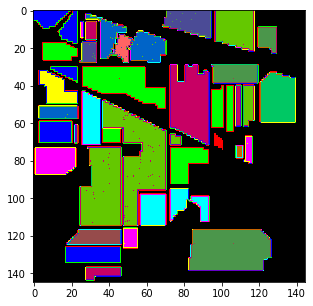

In [29]:
# Plot the Ground Truth Image
ground_truth = spectral.imshow(classes = y,figsize =(5,5))

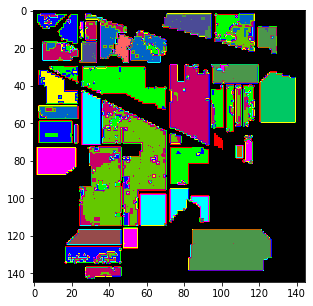

In [30]:
# Plot the Predicted image
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))